A look at the data...

In [1]:
import  os
import yaml
import pandas as pd
import matplotlib.pyplot as plt 
from google.cloud import bigquery
import numpy as np

In [2]:
client = bigquery.Client()

In [3]:
# TODO: fix this
with open(os.path.expanduser("~/.dbt/profiles.yml"), "r") as stream:
    profiles = yaml.safe_load(stream)
PROJECT = profiles['mimic']['outputs']['dev']['project']
DATA = profiles['mimic']['outputs']['dev']['schema']

In [4]:
# Download data.
query_string = """
SELECT *
FROM `{}.{}.insulin_glucose_nutrition`
ORDER BY stay_id,timer
""".format(PROJECT,DATA)

df = (
    client.query(query_string)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)
df = df.loc[~df.stay_id.isnull(),:]
print(df.shape)

(828111, 45)


In [5]:
df.columns = df.columns.str.lower()
print(df.columns)

Index(['subject_id', 'hadm_id', 'stay_id', 'timer', 'timer_next', 'timer_prev',
       'glc', 'glc_next', 'glc_lab', 'glctimer', 'glcsource',
       'input_bolus_push', 'input_bolus_injection', 'input_hrs', 'starttime',
       'endtime', 'gender', 'diabetes_without_cc', 'diabetes_with_cc',
       'weight', 'dod', 'admittime', 'dischtime', 'los_hospital',
       'admission_age', 'ethnicity', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'icu_intime', 'icu_outtime', 'los_icu',
       'icustay_seq', 'first_icu_stay', 'enteral_rate', 'cho_enteral',
       'dextrose_enteral', 'fat_enteral', 'protein_enteral', 'fibre_enteral',
       'calorie_enteral', 'ent_starttime', 'ent_endtime', 'tpn_rate',
       'dextrose_fluid'],
      dtype='object')


In [6]:
df['delta_t'] = (df.timer_next - df.timer).astype('timedelta64[m]')/60.0

In [7]:
# cumulative count
df['n'] = df.groupby(['stay_id']).cumcount().add(1)

In [8]:
# drop if only 1 glucose measure
df_n_glc = df.groupby('stay_id')['glc'].count()
df_n_glc = df_n_glc.to_frame('n_glc')
remove_stay_ids = df_n_glc.loc[df_n_glc.n_glc <= 1,:].index
df = df.loc[~df.stay_id.isin(remove_stay_ids),:]
print(df.shape)

(822124, 47)


In [9]:
# delete rows where final measures are missing
n = df.shape[0]
n_delete = 999
while n_delete > 0:
    df_N = df.groupby('stay_id').size()
    df_N = df_N.to_frame('N')
    df_N = df_N.reset_index(level=0)
    df = df.merge(df_N,left_on='stay_id',right_on='stay_id')
    df = df.loc[~((df.N == df.n) & df.glc_next.isnull()),:]
    df.drop(columns='N',inplace=True)
    n_new = df.shape[0]
    n_delete = n - n_new
    print(n_delete)
    n = n_new
print(df.shape)

44337
2002
186
21
3
1
0
(775574, 47)


In [10]:
# drop if before first glucose
df['msk0'] = 1.0*(df['glc'].isnull())
df['sum_msk0'] = df.groupby('stay_id')['msk0'].cumsum()
df = df.loc[~(df.sum_msk0 == df.n),:]
# redo cumulative count
df.drop(columns=['n'],inplace=True)
df['n'] = df.groupby(['stay_id']).cumcount().add(1)

In [11]:
df.loc[df.delta_t == 0.0,:]

,subject_id,hadm_id,stay_id,timer,timer_next,timer_prev,glc,glc_next,glc_lab,glctimer,...,fibre_enteral,calorie_enteral,ent_starttime,ent_endtime,tpn_rate,dextrose_fluid,delta_t,msk0,sum_msk0,n


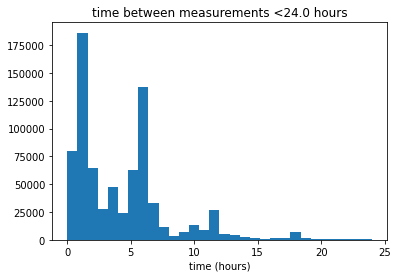

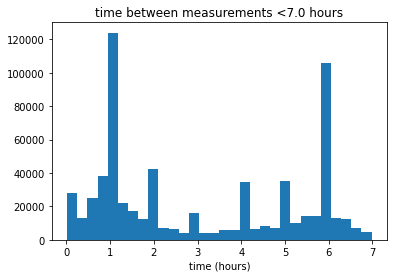

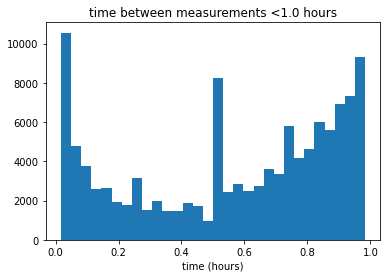

In [12]:
for t in [24.0,7.0,1.0]:
    plt.hist(df.loc[df.delta_t < t,:].delta_t,bins=30)
    plt.title("time between measurements <{} hours".format(t))
    plt.xlabel("time (hours)")
    plt.show()

### Scaling of treatment

In [50]:
df.loc[df.input_hrs > 50,'input_hrs'] = np.median(df.input_hrs[df.input_hrs > 0])
df.loc[df.input_bolus_injection > 50,'input_bolus_injection'] = np.median(df.input_bolus_injection[df.input_bolus_injection > 0])
df.loc[df.input_bolus_push > 50,'input_bolus_push'] = np.median(df.input_bolus_push[df.input_bolus_push > 0])

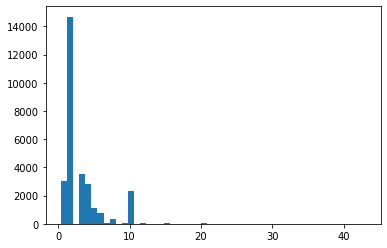

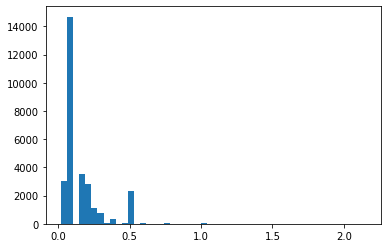

In [56]:
plt.hist(df.loc[df.input_bolus_push > 0.0,'input_bolus_push'],bins=50)
plt.show()
plt.hist(df.loc[df.input_bolus_push > 0.0,'input_bolus_push'] / 20.0,bins=50)
plt.show()

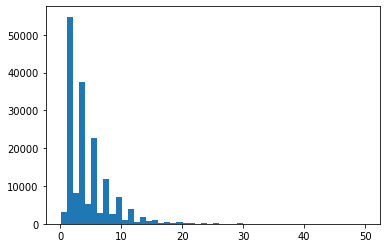

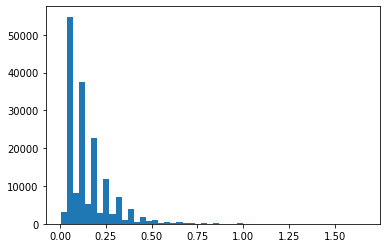

In [54]:
plt.hist(df.loc[df.input_bolus_injection > 0.0,'input_bolus_injection'],bins=50)
plt.show()
plt.hist(df.loc[df.input_bolus_injection > 0.0,'input_bolus_injection'] / 30.0,bins=50)
plt.show()

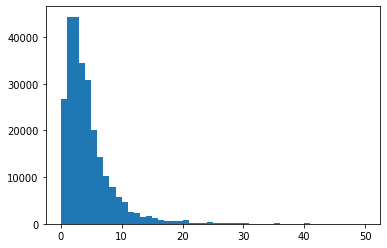

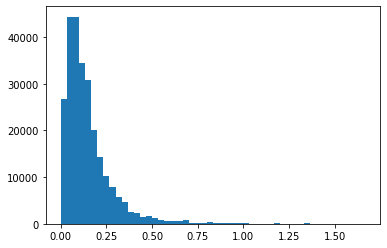

In [47]:
# scale insulin variables
plt.hist(df.loc[df.input_hrs > 0.0,'input_hrs'],bins=50)
plt.show()
plt.hist(df.loc[df.input_hrs > 0.0,'input_hrs']/30.0,bins=50)
plt.show()

In [13]:
df['gender_m'] = 1.0*(df['gender'] == 'M')

### Variable creation

In [14]:
df['msk'] = 1.0*(df['glc_next'].isnull())
print(sum(df['msk']))

46193.0


In [15]:
df['timer_d'] = (df.timer - df.icu_intime).astype('timedelta64[m]')/60.0
df['timer_next_d'] = (df.timer_next - df.icu_intime).astype('timedelta64[m]')/60.0

### imputations

In [16]:
df['glc'] = df.groupby('stay_id')['glc'].apply(lambda x: x.fillna(x.interpolate()))
df['glc'] = df.groupby('stay_id')['glc'].apply(lambda x: x.fillna(x.interpolate(limit=2, limit_direction='backward')))

In [17]:
print(sum(df.glc.isnull()))

0


In [18]:
df.loc[df.glc.isnull(),:]

,subject_id,hadm_id,stay_id,timer,timer_next,timer_prev,glc,glc_next,glc_lab,glctimer,...,tpn_rate,dextrose_fluid,delta_t,msk0,sum_msk0,n,gender_m,msk,timer_d,timer_next_d


In [19]:
fillzero_vars = ['input_bolus_push','input_bolus_injection','input_hrs',
            'enteral_rate','cho_enteral','dextrose_enteral','fat_enteral',
            'protein_enteral','fibre_enteral','calorie_enteral','tpn_rate',
            'dextrose_fluid']
for var in fillzero_vars:
    df[var] = df[var].fillna(0)

### Statistics

In [20]:
print("number of ICU stays:",len(df.stay_id.unique()))
print("number of hospital stays:",len(df.hadm_id.unique()))
print("number of patients:",len(df.subject_id.unique()))

number of ICU stays: 44337
number of hospital stays: 40954
number of patients: 33560


In [21]:
print("median age:",df.groupby('stay_id').admission_age.min().median())

median age: 67.0


In [22]:
print("diabetes (uncomplicated):",df.groupby('hadm_id').diabetes_without_cc.max().sum())
print("diabetes (complicated):",df.groupby('hadm_id').diabetes_with_cc.max().sum())

diabetes (uncomplicated): 13780
diabetes (complicated): 6162


In [23]:
print('no change prediction: {}'.format(np.sqrt(np.mean((df.glc - df.glc_next)**2))))

no change prediction: 42.62244031429739


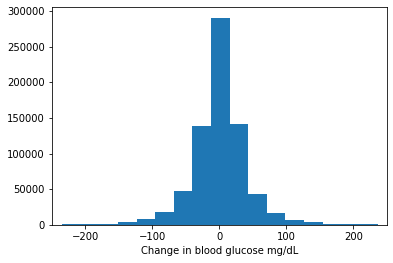

In [24]:
plt.hist(df.glc - df.glc_next,bins=60)
plt.xlim(-250,250)
plt.xlabel('Change in blood glucose mg/dL')
plt.show()

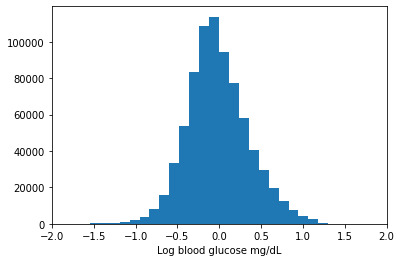

In [25]:
plt.hist(np.log(df.glc) - 5,bins=60)
plt.xlim(-2,2)
plt.xlabel('Log blood glucose mg/dL')
plt.show()

### Save

In [26]:
df.to_csv('../data/mimic.csv',index_label='rn')